<a href="https://colab.research.google.com/github/Bambani2003/Data_Science_Projects/blob/main/Anomaly_Detection/Creadit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Creating a comprehensive fraud detection system for a credit card company**

In [3]:
# Modules

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import folium                               # Used for data visualisation

**EDA**

In [4]:
# Reading data

card_info = pd.read_csv('/content/CreditCardInfo.csv')
transaction_info = pd.read_csv('/content/Transactions.csv')

In [5]:
# Checking the values and features of the datasets

print(card_info.head())
print(transaction_info.head())

        credit_card      city state  zipcode  credit_card_limit
0  1280981422329509    Dallas    PA    18612               6000
1  9737219864179988   Houston    PA    15342              16000
2  4749889059323202    Auburn    MA     1501              14000
3  9591503562024072   Orlando    WV    26412              18000
4  2095640259001271  New York    NY    10001              20000
        credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08                     103.15   
2  1003715054175576  2015-10-26 18:19:36                      48.55   
3  1003715054175576  2015-10-22 19:41:10                     136.18   
4  1003715054175576  2015-10-26 20:08:22                      71.82   

        Long        Lat  
0 -80.174132  40.267370  
1 -80.194240  40.180114  
2 -80.211033  40.313004  
3 -80.174138  40.290895  
4 -80.238720  40.166719  


In [6]:
# Missing value treatment

print(card_info.isnull().sum())
print(transaction_info.isnull().sum())

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64
credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64


In [7]:
# Since there are no missing values, we can MERGE the dataset

df = transaction_info.merge(card_info, on = 'credit_card')
print(df.head())
print(df.shape)

        credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08                     103.15   
2  1003715054175576  2015-10-26 18:19:36                      48.55   
3  1003715054175576  2015-10-22 19:41:10                     136.18   
4  1003715054175576  2015-10-26 20:08:22                      71.82   

        Long        Lat     city state  zipcode  credit_card_limit  
0 -80.174132  40.267370  Houston    PA    15342              20000  
1 -80.194240  40.180114  Houston    PA    15342              20000  
2 -80.211033  40.313004  Houston    PA    15342              20000  
3 -80.174138  40.290895  Houston    PA    15342              20000  
4 -80.238720  40.166719  Houston    PA    15342              20000  
(294588, 9)


<ipython-input-8-7f9b9631f2ce>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='viridis_r', fmt='.2f')


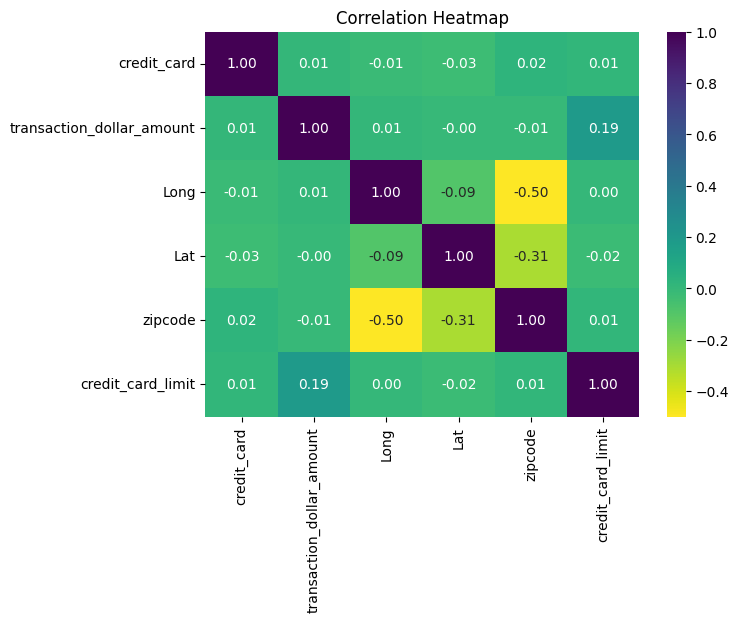

In [8]:
# Seaborn heat map

plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(), annot=True, cmap='viridis_r', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Inference**
*   There is no serious correlation between any of the features

In [9]:
# Looking at other feautures such as number of transaction records per state (Copied from Kaggle)

def visualize_total_transactions_on_map(df):
    city_total_transactions = df.groupby('city')['transaction_dollar_amount'].sum().reset_index()

    map_center_lat = df['Lat'].mean()
    map_center_lon = df['Long'].mean()
    map_osm = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=10)

    max_total_transactions = city_total_transactions['transaction_dollar_amount'].max()

    for index, row in city_total_transactions.iterrows():
        city = row['city']
        total_transactions = row['transaction_dollar_amount']

        marker_size = total_transactions / max_total_transactions * 50  # Adjust the scaling factor as needed

        popup_text = f"City: {city}<br>Total Transactions: ${total_transactions:.2f}"

        marker = folium.CircleMarker(
            location=[df[df['city'] == city]['Lat'].mean(), df[df['city'] == city]['Long'].mean()],
            radius=marker_size,
            popup=popup_text,
            tooltip=city,
            fill=True,
            fill_opacity=0.7
        )

        marker.add_to(map_osm)

    return map_osm

if __name__ == "__main__":

    map_total_transactions = visualize_total_transactions_on_map(df)
    display(map_total_transactions)

**Inference:**
* Most of the transactions are in New Hampshire and Pennsylvania and most of the fraudulent ones could be from there as well.

<Axes: >

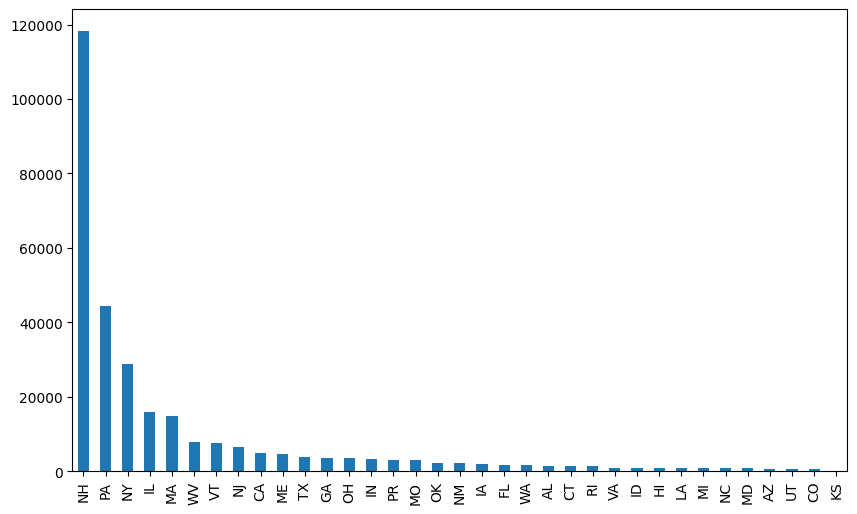

In [10]:
# Checking the above inference

df['state'].value_counts().plot(kind='bar', figsize = (10,6))

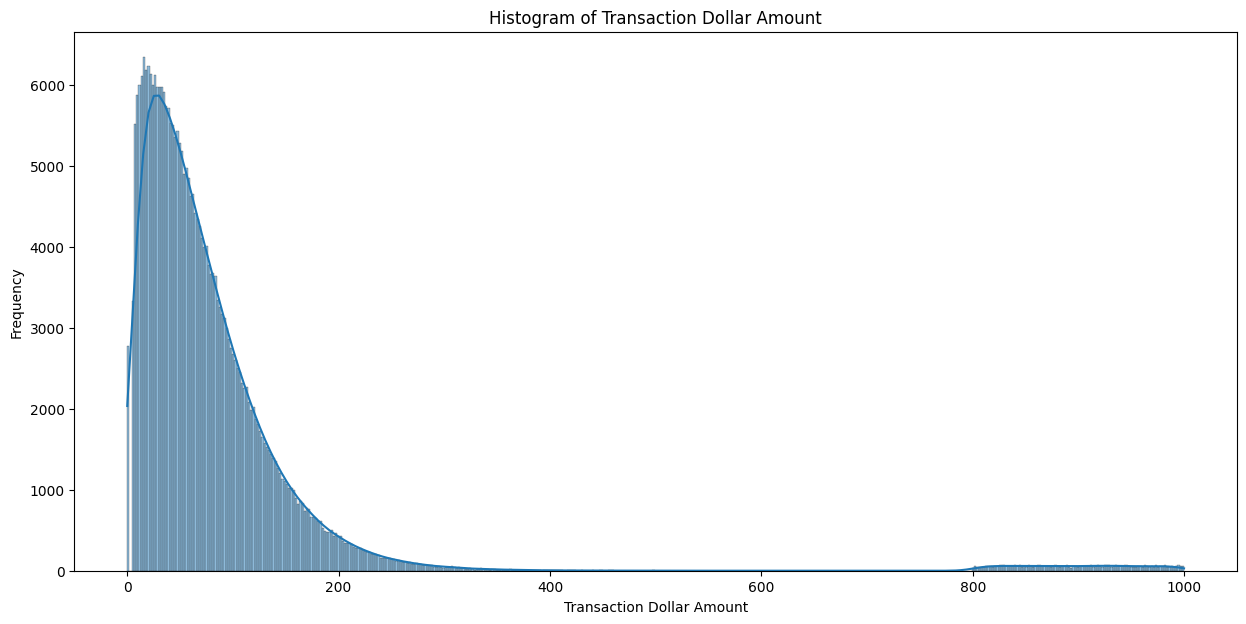

In [11]:
# Histogram of 'transaction_dollar_amount'

plt.figure(figsize=(15, 7))
sns.histplot(df['transaction_dollar_amount'], kde=True)
plt.title('Histogram of Transaction Dollar Amount')
plt.xlabel('Transaction Dollar Amount')
plt.ylabel('Frequency')
plt.show()

**Inference**
* Most transactions are of less than $200 which could mean most of the fraudulent ones are of a small amount.

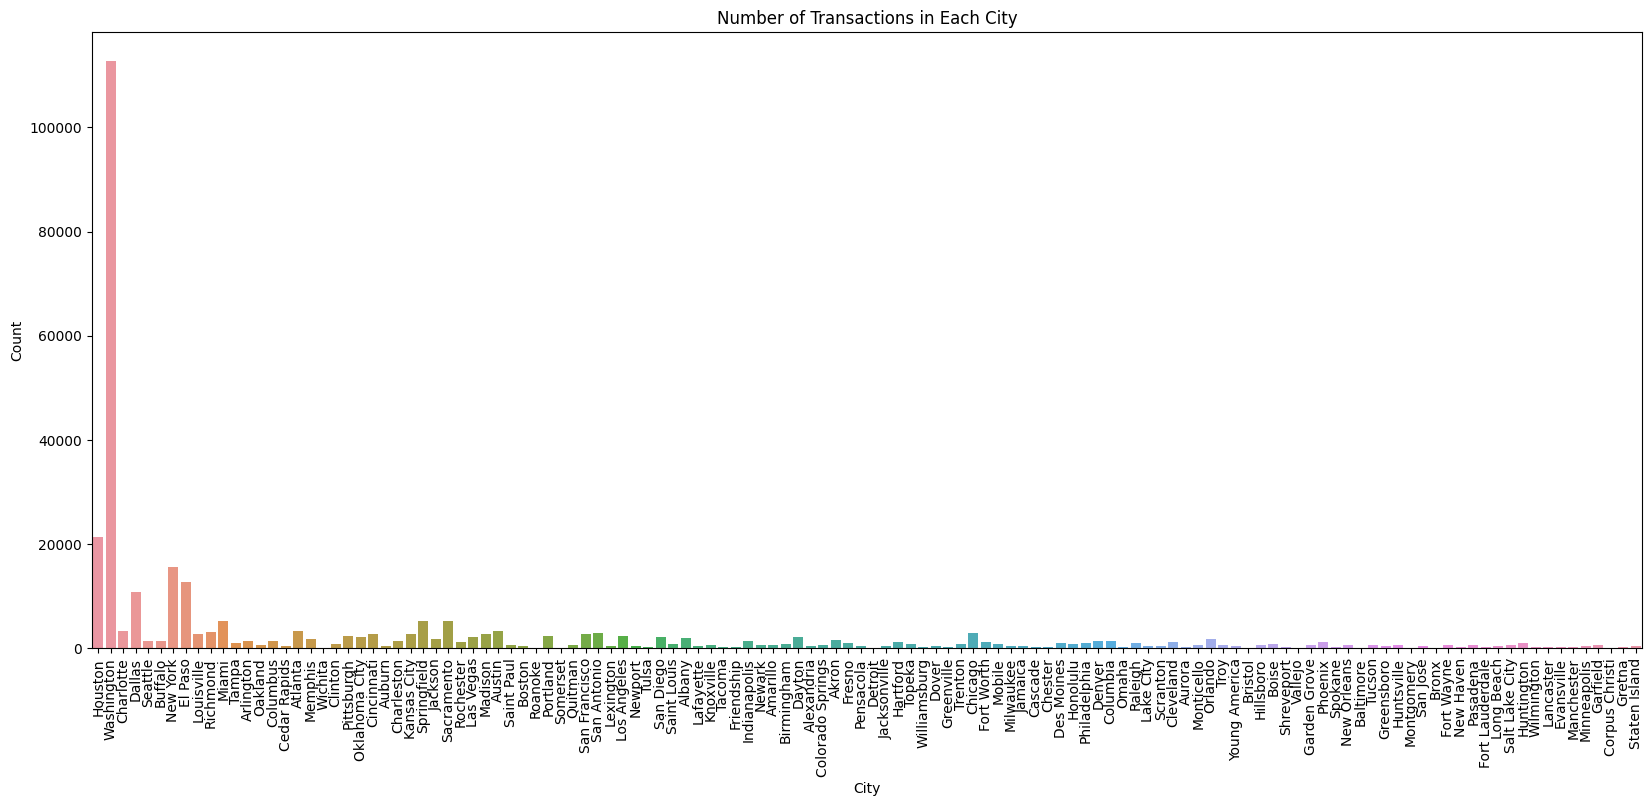

In [12]:
#Bar chart of the count of transactions in each city

plt.figure(figsize=(20, 8))
sns.countplot(data=df, x='city')
plt.title('Number of Transactions in Each City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

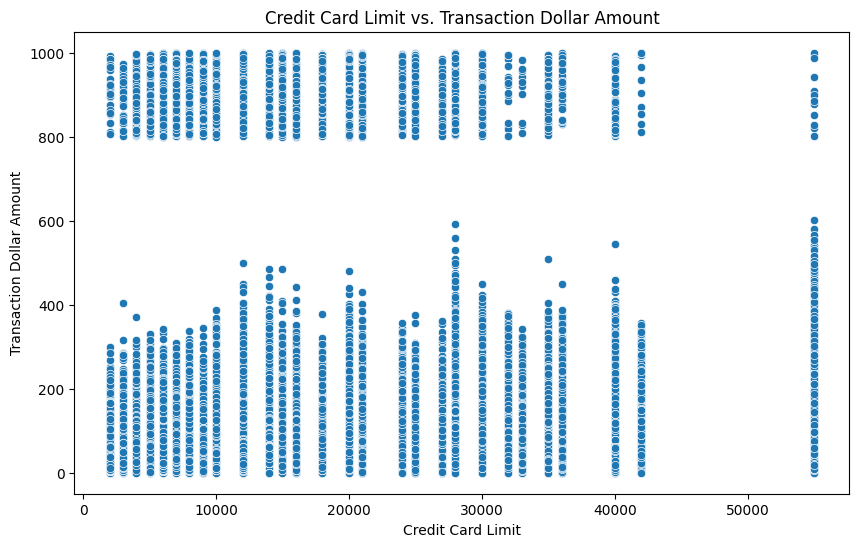

In [13]:
#'transaction_dollar_amount' vs. 'credit_card_limit'

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='credit_card_limit', y='transaction_dollar_amount')
plt.title('Credit Card Limit vs. Transaction Dollar Amount')
plt.xlabel('Credit Card Limit')
plt.ylabel('Transaction Dollar Amount')
plt.show()

**Building the Fraud Detection model**

In [14]:
# Class of model and functions including normalisation, K-means, training and evaluation of NN etc.

class FraudDetectionModel:
    def __init__(self, df):
        self.df = df
        self.feature_columns = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit']
        self.model = None
        self.kmeans = None

    def data_preprocessing(self):
        scaler = StandardScaler()
        self.df[self.feature_columns] = scaler.fit_transform(self.df[self.feature_columns])

    def build_kmeans(self, n_clusters=2):
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def create_labels(self):
        if self.kmeans is None:
            raise ValueError("K-means model has not been built yet. Please call 'build_kmeans' first.")

        self.kmeans.fit(self.df[self.feature_columns])

        self.df['cluster_label'] = self.kmeans.predict(self.df[self.feature_columns])

        cluster_fraud_label = self.df.groupby('cluster_label')['transaction_dollar_amount'].mean().idxmax()
        self.df['is_fraudulent'] = self.df['cluster_label'].apply(lambda x: 1 if x == cluster_fraud_label else 0)


    def visualize_fraudulent_transactions(self):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x='credit_card_limit', y='transaction_dollar_amount', hue = 'is_fraudulent')
        plt.title('Credit Card Limit vs. Transaction Dollar Amount')
        plt.xlabel('Credit Card Limit')
        plt.ylabel('Transaction Dollar Amount')
        plt.show()

    def build_model(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(len(self.feature_columns),)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self, X_train, y_train, epochs=10, batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    def evaluate_model(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)

        y_pred = (self.model.predict(X_test) > 0.5).astype(int).flatten()
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


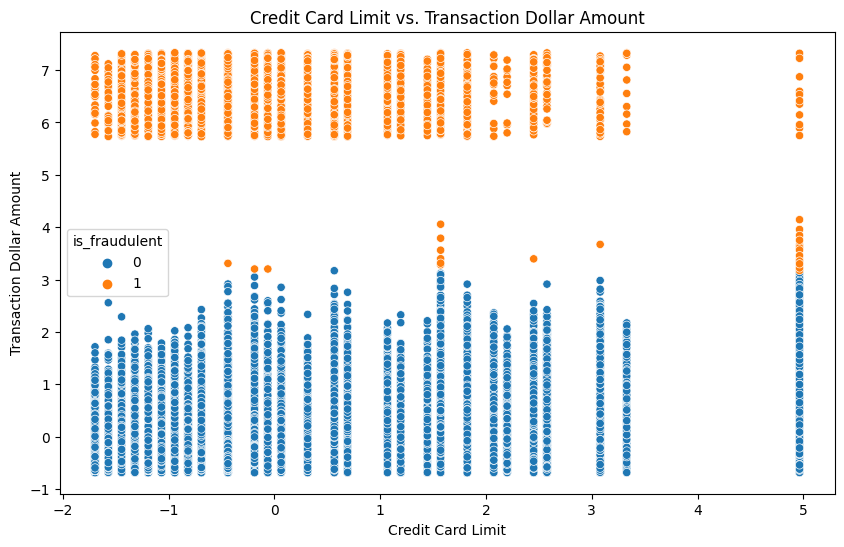

Epoch 1/10
7365/7365 - 12s - loss: 0.0052 - accuracy: 0.9993 - 12s/epoch - 2ms/step
Epoch 2/10
7365/7365 - 11s - loss: 2.4151e-04 - accuracy: 0.9999 - 11s/epoch - 2ms/step
Epoch 3/10
7365/7365 - 11s - loss: 2.0630e-04 - accuracy: 0.9999 - 11s/epoch - 1ms/step
Epoch 4/10
7365/7365 - 11s - loss: 2.1639e-04 - accuracy: 0.9999 - 11s/epoch - 2ms/step
Epoch 5/10
7365/7365 - 11s - loss: 2.2843e-04 - accuracy: 0.9999 - 11s/epoch - 2ms/step
Epoch 6/10
7365/7365 - 11s - loss: 1.7769e-04 - accuracy: 0.9999 - 11s/epoch - 2ms/step
Epoch 7/10
7365/7365 - 11s - loss: 1.9666e-04 - accuracy: 0.9999 - 11s/epoch - 2ms/step
Epoch 8/10
7365/7365 - 11s - loss: 1.2914e-04 - accuracy: 1.0000 - 11s/epoch - 2ms/step
Epoch 9/10
7365/7365 - 11s - loss: 1.5716e-04 - accuracy: 1.0000 - 11s/epoch - 2ms/step
Epoch 10/10
7365/7365 - 11s - loss: 1.8293e-04 - accuracy: 0.9999 - 11s/epoch - 1ms/step
Model Training Complete.
1842/1842 [==============================] - 3s 2ms/step
Classification Report:
              prec

In [15]:
# Instantiating the class

model = FraudDetectionModel(df)
model.data_preprocessing()
model.build_kmeans()
model.create_labels()

model.visualize_fraudulent_transactions()

X = model.df[model.feature_columns].values
y = model.df['is_fraudulent'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.build_model()
model.train_model(X_train, y_train, epochs=10, batch_size=32)

print("Model Training Complete.")

model.evaluate_model(X_test, y_test)

That's a little suspicious, getting 100% accuracy and an F1 score of 1.

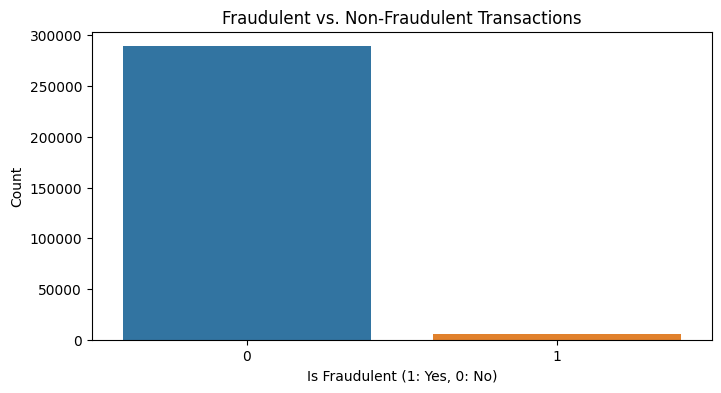

In [16]:
# Visualising how many were classified as fraudulent

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='is_fraudulent')
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraudulent (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()

<ipython-input-17-2565cdafbed1>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


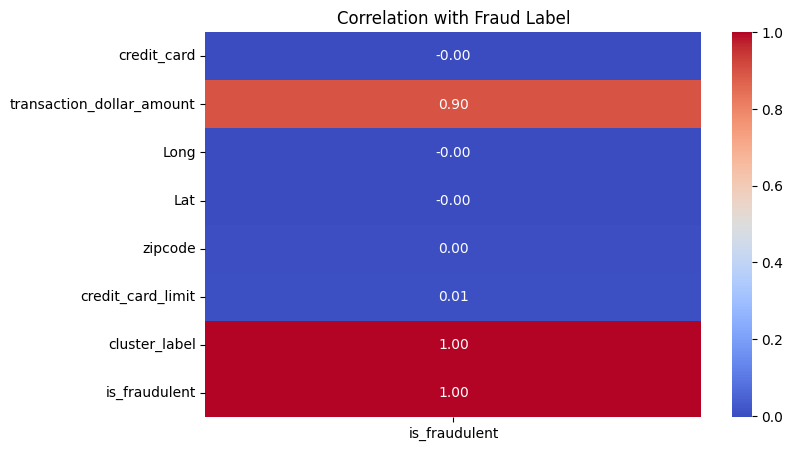

In [17]:
#correlation of fraud transaction with other features

plt.figure(figsize=(8, 5))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix[['is_fraudulent']], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with Fraud Label')
plt.show()

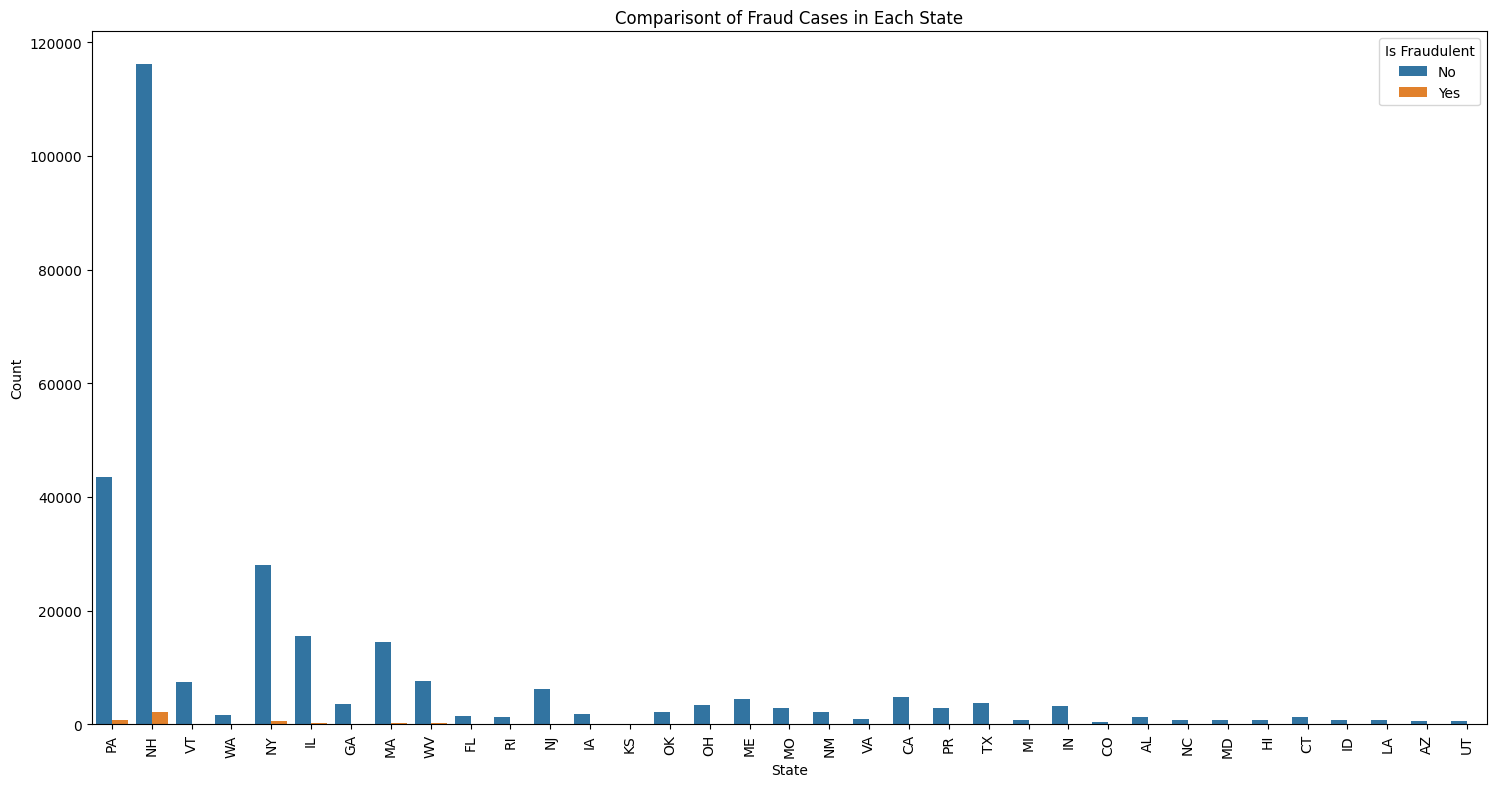

In [18]:
# Fraudulent cases in each state

plt.figure(figsize=(18, 9))
sns.countplot(data=df, x='state', hue='is_fraudulent')
plt.title('Comparisont of Fraud Cases in Each State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Is Fraudulent', labels=['No', 'Yes'])
plt.show()